In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from financepy.utils import *
from financepy.products.equity import *
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Implied Density from Terminal Stock Price  & Volatility Skew

This notebook is about determining the implied density of the terminal stock price fromthe volatility skew.

Suppose that we have managed to fit the 1-year volatility smile of the equity option market using a function

σ(x) = ax2 + bx + c

where x is the ”moneyness” (x = K/S(0)) and the initial stock price S(0) = 100
and a = 0.025, b = −0.225 and c = 0.50.

We build a function that extracts the
market-implied distribution of S(T) at a 1-year horizon from σ(x) using the Breedon-
Litzenberger formula we derived in class.

In [2]:
# Function to calculate the market-implied probability distribution
def calculate_market_implied_distribution(S, r, a, b, c):
    
    # Initialize parameters
    dividend_yield = 0
    time_to_maturity = 1  # in years
    valuation_date = Date(1, 1, 2020)
    expiry_date = valuation_date.add_years(time_to_maturity)
    discount_curve = DiscountCurveFlat(valuation_date, r)
    dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
    
    # Lists to store computed values
    moneyness_list = [0]
    implied_vol_list = [0]
    call_option_values = [0]
    
    # Compute moneyness, implied volatility, and call option values
    for K in range(1, 201):
        moneyness = K / S
        implied_volatility = a * moneyness**2 + b * moneyness + c
        model = BlackScholes(implied_volatility)
        call_option = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_CALL)
        option_value = call_option.value(valuation_date, S, discount_curve, dividend_curve, model)
        
        # Append to respective lists
        moneyness_list.append(moneyness)
        implied_vol_list.append(implied_volatility)
        call_option_values.append(option_value)
    
    # Create a DataFrame with computed values
    market_data = pd.DataFrame({
        "moneyness": moneyness_list,
        "implied_volatility": implied_vol_list,
        "call_option_value": call_option_values
    })
    
    # Compute probability density using Breeden-Litzenberger formula
    for i in range(2, len(market_data) - 1):
        market_data.loc[i, "density"] = (
            market_data.loc[i - 1, "call_option_value"] +
            market_data.loc[i + 1, "call_option_value"] -
            2 * market_data.loc[i, "call_option_value"]
        ) * (1 / exp(-r * time_to_maturity))
    
    # Remove unnecessary columns and return cleaned DataFrame
    market_data.drop(columns=["call_option_value", "implied_volatility"], inplace=True)
    return market_data

In [3]:
S_0 = 100
r = 0.05
a = 0.025
b = -0.225
c = 0.5
market = calculate_market_implied_distribution(S_0, r, a, b, c)

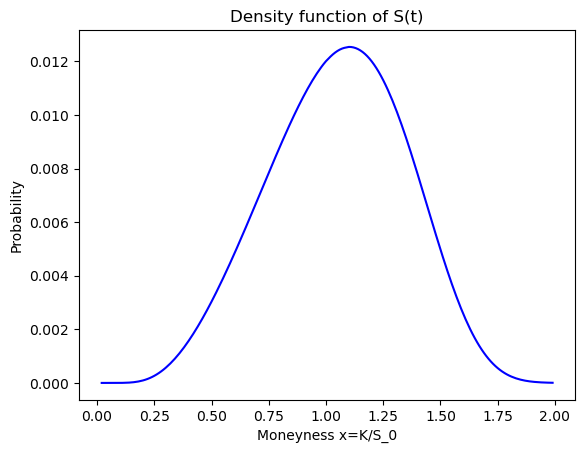

In [4]:
plt.plot(market["moneyness"], market["density"], c="b")
plt.title("Density function of S(t)")
plt.xlabel("Moneyness x=K/S_0")
plt.ylabel("Probability")
plt.show()

A digital call option pays $1 if S(T) > K and zero otherwise. Using the probability
density function implied by this volatility smile, we calculate a table of prices of the 1-
year European digital call option with strikes at K = 60, 80, 100, 120, 140. Assume
that r = 5% and q = 0.0%.

To price the digital call, we have to compute the payoff of the digital call and to discount it to the valuation date. The payoff of the digital call is 1 multiplied by the probability that the stock goes beyond the strike K.

In [6]:
def price_digit_density(K, r, T):
    price = 0
    for i in range(K,200):
        price += market.iloc[i,1] # adding the density probability for values beyond K
    price = price * exp(-r*T)
    return price

In [7]:
digit_prices = []
strikes = np.linspace(60, 140, 5)
r=0.05
T=1 
# inline loop
digit_prices = [price_digit_density(int(k), r, T) for k in strikes]

digit_prices_df = pd.DataFrame({"Strike": strikes, "Digit_Price_density": digit_prices})

# Display the DataFrame
print(digit_prices_df)

   Strike  Digit_Price_density
0    60.0             0.881905
1    80.0             0.753863
2   100.0             0.553943
3   120.0             0.318878
4   140.0             0.123118


Now we price these digitals using BS

In [8]:
# Initializing values
S0=100
r=0.05
dividend_yield=0
T=1
valuation_date = Date(1,1,2020)
expiry_date = valuation_date.add_years(T)
discount_curve = DiscountCurveFlat(valuation_date, r)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
a=0.025
b=-0.225
c=0.5

strike=[]
digit_bs=[]
for i in [60,80,100,120,140]: #computing the price with the implied vol each time
    digital=EquityDigitalOption(expiry_date, i, OptionTypes.EUROPEAN_CALL, FinDigitalOptionTypes.CASH_OR_NOTHING)
    model=BlackScholes(a*(i/100)**2+b*(i/100)+c)
    digital_value=digital.value(valuation_date, S_0, discount_curve, dividend_curve, model) # we price using financepy classe & methods
    strike.append(i)
    digit_bs.append(digital_value)

In [9]:
digit_prices_df["Digit_Price_BS"] = digit_bs
digit_prices_df["Diff"] = digit_prices_df["Digit_Price_density"] - digit_prices_df["Digit_Price_BS"]
digit_prices_df.set_index("Strike", inplace=True)
digit_prices_df

,Digit_Price_density,Digit_Price_BS,Diff
Strike,,,
60.0,0.881905,0.860806,0.021099
80.0,0.753863,0.703984,0.049879
100.0,0.553943,0.481775,0.072168
120.0,0.318878,0.251470,0.067408
140.0,0.123118,0.085770,0.037349


The pricing derived from the density function consistently overestimates the Black-Scholes price by a roughly constant amount. This implies that as the strike price increases, the percentage difference between the two prices also grows. This suggests that the density function assigns excessive weight to extreme values, resulting in fatter tails than what is observed in reality. Consequently, the digital call priced using the density function appears overpriced.

Additionally, the implied distribution of the stock price deviates from a perfectly lognormal shape, which contributes to the observed pricing differences. This discrepancy highlights why the Black-Scholes model, which assumes a lognormal distribution, produces more accurate results in this context.

The idea is to use the fact that the price of a derivatives should be the payoff at maturity, discounted for the time value

For this option, we will get the put payoff only if the barrier is crossed. It means that we will get the K-S(t) payoff only if S(t) is inferior to B=60. So we will value this put through its expectation which is the probability to have the strike price below 60, and each time the strike price is below 60, we will get 100 - S(t) payoff. 

This payoff is discounted at exp(-rt) to get the put option value.

In [11]:
# our previous parameters are still good, we only need to precise the barrier level
B=60
K=100
payoff=0
# market-implied distrubition of 1 with the Breedon-Litzenberg formula isn't available
for i in range(2,61): 
    payoff = payoff + (K-i) * market.iloc[i,1]
put_price = payoff *exp(-r*T)
print("The Down-and-In put price with K=100 and B=60 is: {:.4f}".format(put_price))

The Down-and-In put price with K=100 and B=60 is: 3.7797
